# Comment sentiment analysis

## 1) Import dependencies

In [164]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [165]:
df = pd.read_csv('jigsaw-toxic-comment-classification-challenge/train.csv')

## 2)Know the data

In [168]:
df[(df['severe_toxic'] == 1) & (df['toxic'] == 1)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
181,006e87872c8b370c,you are a stupid fuck \n\nand your mother's cu...,1,1,1,0,1,0
442,01208d2b76624130,Hi \n\nIm a fucking bitch.\n\n50.180.208.181,1,1,1,0,1,0
579,018663f910e0bfe6,What a motherfucking piece of crap those fuckh...,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...
159096,f871b05d4caa6f20,"You filthy, stinking crow! \n\nI am back! Dirt...",1,1,1,0,1,0
159099,f885a3e2d779342e,now\n\nyou fucking pathetic moron. \n\ncc: Ji...,1,1,1,0,1,0
159281,fb726deec64157bd,LoL!! \n\nyou're GAY!! you will never know how...,1,1,1,0,1,1
159312,fbf20e312cd4a78d,"Walter Mercado \n\nAntonio, quite frankly, you...",1,1,1,0,1,0


Observe that when a comment is severe toxic, it is also toxic, to simplify our model we will just remove the severely toxic column. This decision was made because there is no clear boundary of differences between the two categories: toxic and severe_toxic

In [169]:
df = df.drop(columns=['severe_toxic'])

In [170]:
df.head()

,id,comment_text,toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0


## 3) Preprocess the data

In [171]:
from tensorflow.keras.layers import TextVectorization

In [172]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [173]:
MAX_FEATURES = 200000

In [174]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [175]:
vectorizer.adapt(X.values)

In [152]:
vectorized_text = vectorizer(X.values)

## 4) Fix imbalance in data by SMOTE

In [176]:
from collections import Counter
print('toxic',sorted(Counter(df['toxic']).items()))
print('obscene',sorted(Counter(df['obscene']).items()))
print('threat',sorted(Counter(df['threat']).items()))
print('insult',sorted(Counter(df['insult']).items()))
print('identity_hate',sorted(Counter(df['identity_hate']).items()))

toxic [(0, 144277), (1, 15294)]
obscene [(0, 151122), (1, 8449)]
threat [(0, 159093), (1, 478)]
insult [(0, 151694), (1, 7877)]
identity_hate [(0, 158166), (1, 1405)]


We can see that many classes are imbalanced, if we do not fix this, our model will be unable to identify true positives or false negatives.

In [154]:
from imblearn.over_sampling import SMOTE

In [155]:
labels = ['toxic', 'obscene', 'threat', 'insult', 'identity_hate']
oversampled_data = {}
smote = SMOTE(sampling_strategy='auto', random_state=42)

In [156]:
for label in labels:
    y = df[label].values  

    # SMOTE 
    X_resampled, y_resampled = smote.fit_resample(vectorized_text, y)

    # oversampled
    oversampled_data[label] = (X_resampled, y_resampled)

    unique, counts = np.unique(y_resampled, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f'label : {label}')
    print('0 =>', class_counts[0])
    print('1 =>', class_counts[1])

label : toxic
0 => 144277
1 => 144277
label : obscene
0 => 151122
1 => 151122
label : threat
0 => 159093
1 => 159093
label : insult
0 => 151694
1 => 151694
label : identity_hate
0 => 158166
1 => 158166


## 5) Sequential model

In [157]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [158]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES + 1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(1, activation='sigmoid'))

In [159]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

## 6) Train each category 

In [160]:
result = {}

label:  toxic
Epoch 1/4
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - AUC: 0.9132 - Precision: 0.8307 - Recall: 0.8411 - accuracy: 0.8352 - loss: 0.3596
Epoch 1: saving model to models/model_toxic_1.keras
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 2767s 328ms/step - AUC: 0.9132 - Precision: 0.8307 - Recall: 0.8411 - accuracy: 0.8352 - loss: 0.3596 - val_AUC: 0.9870 - val_Precision: 0.9503 - val_Recall: 0.9487 - val_accuracy: 0.9497 - val_loss: 0.1407
Epoch 2/4
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - AUC: 0.9874 - Precision: 0.9522 - Recall: 0.9434 - accuracy: 0.9480 - loss: 0.1385
Epoch 2: saving model to models/model_toxic_2.keras
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 2847s 338ms/step - AUC: 0.9874 - Precision: 0.9522 - Recall: 0.9434 - accuracy: 0.9480 - loss: 0.1385 - val_AUC: 0.9946 - val_Precision: 0.9765 - val_Recall: 0.9620 - val_accuracy: 0.9693 - val_loss: 0.0885
Epoch 3/4
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - AUC: 0.9941 - Precision: 0.9691 - Recall: 0.9640 - accuracy: 0.9667 -

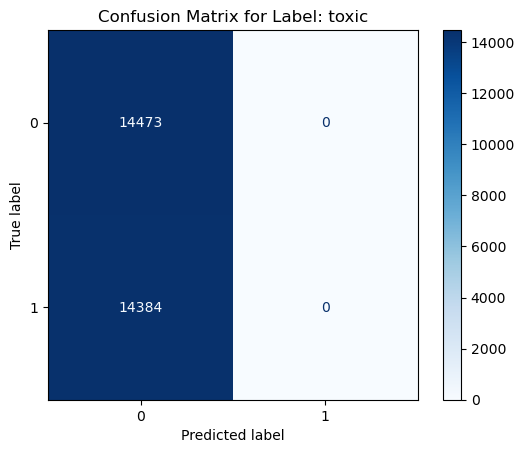

<Figure size 800x500 with 0 Axes>

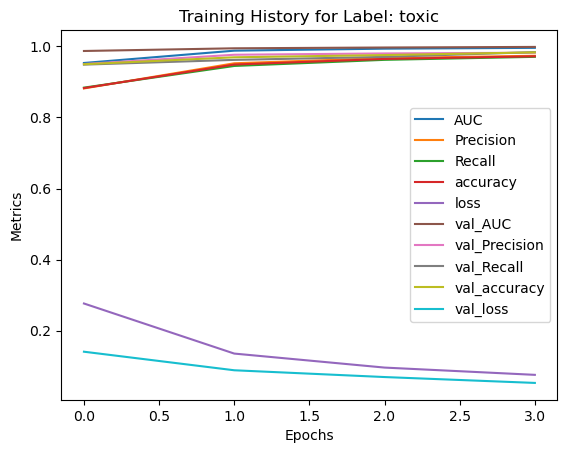

label:  obscene
Epoch 1/4
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - AUC: 0.9947 - Precision: 0.9655 - Recall: 0.9691 - accuracy: 0.9672 - loss: 0.0872
Epoch 1: saving model to models/model_obscene_1.keras
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 2888s 327ms/step - AUC: 0.9947 - Precision: 0.9655 - Recall: 0.9691 - accuracy: 0.9672 - loss: 0.0872 - val_AUC: 0.9979 - val_Precision: 0.9820 - val_Recall: 0.9791 - val_accuracy: 0.9806 - val_loss: 0.0527
Epoch 2/4
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - AUC: 0.9978 - Precision: 0.9804 - Recall: 0.9807 - accuracy: 0.9806 - loss: 0.0524
Epoch 2: saving model to models/model_obscene_2.keras
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 2956s 335ms/step - AUC: 0.9978 - Precision: 0.9804 - Recall: 0.9807 - accuracy: 0.9806 - loss: 0.0524 - val_AUC: 0.9991 - val_Precision: 0.9900 - val_Recall: 0.9816 - val_accuracy: 0.9858 - val_loss: 0.0390
Epoch 3/4
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - AUC: 0.9985 - Precision: 0.9859 - Recall: 0.9844 - accuracy: 0.

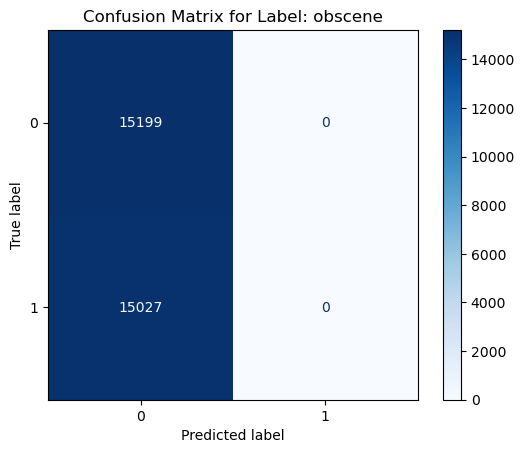

<Figure size 800x500 with 0 Axes>

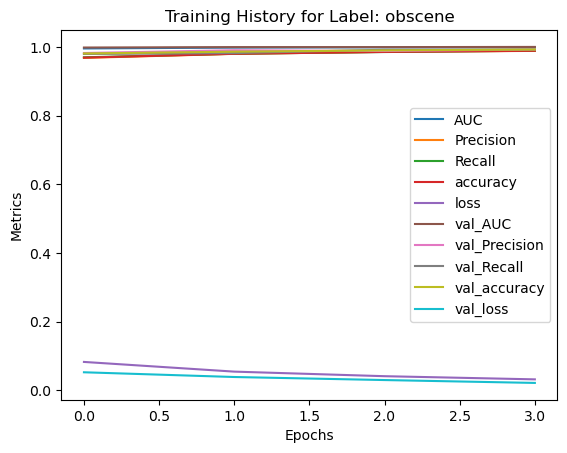

label:  threat
Epoch 1/4
9281/9281 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - AUC: 0.9983 - Precision: 0.9868 - Recall: 0.9858 - accuracy: 0.9862 - loss: 0.0413
Epoch 1: saving model to models/model_threat_1.keras
9281/9281 ━━━━━━━━━━━━━━━━━━━━ 2991s 322ms/step - AUC: 0.9983 - Precision: 0.9868 - Recall: 0.9858 - accuracy: 0.9862 - loss: 0.0413 - val_AUC: 0.9995 - val_Precision: 0.9964 - val_Recall: 0.9922 - val_accuracy: 0.9944 - val_loss: 0.0188
Epoch 2/4
9281/9281 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - AUC: 0.9993 - Precision: 0.9949 - Recall: 0.9927 - accuracy: 0.9938 - loss: 0.0203
Epoch 2: saving model to models/model_threat_2.keras
9281/9281 ━━━━━━━━━━━━━━━━━━━━ 3019s 325ms/step - AUC: 0.9993 - Precision: 0.9949 - Recall: 0.9927 - accuracy: 0.9938 - loss: 0.0203 - val_AUC: 0.9997 - val_Precision: 0.9974 - val_Recall: 0.9959 - val_accuracy: 0.9966 - val_loss: 0.0116
Epoch 3/4
9281/9281 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - AUC: 0.9996 - Precision: 0.9968 - Recall: 0.9955 - accuracy: 0.996

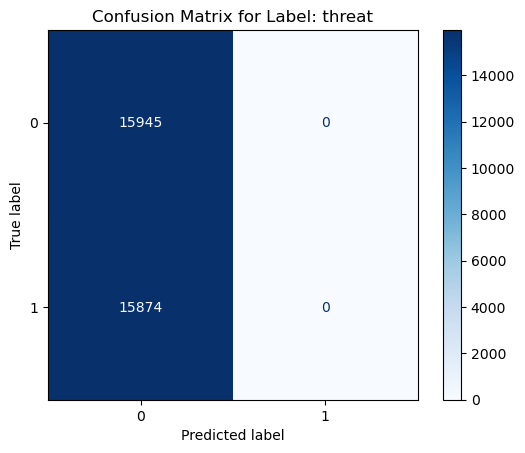

<Figure size 800x500 with 0 Axes>

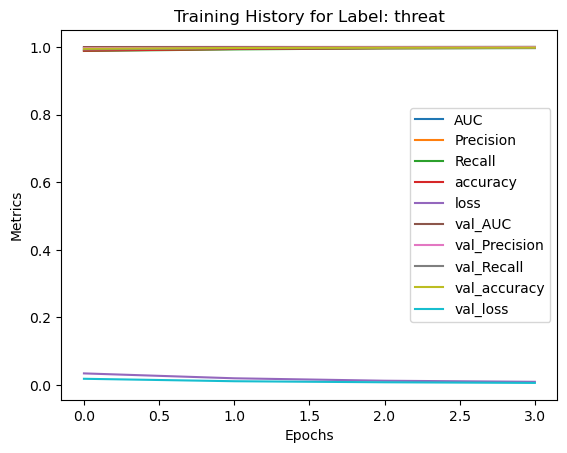

label:  insult
Epoch 1/4
8849/8849 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - AUC: 0.9968 - Precision: 0.9827 - Recall: 0.9721 - accuracy: 0.9775 - loss: 0.0615
Epoch 1: saving model to models/model_insult_1.keras
8849/8849 ━━━━━━━━━━━━━━━━━━━━ 2972s 336ms/step - AUC: 0.9968 - Precision: 0.9827 - Recall: 0.9721 - accuracy: 0.9775 - loss: 0.0615 - val_AUC: 0.9989 - val_Precision: 0.9825 - val_Recall: 0.9876 - val_accuracy: 0.9850 - val_loss: 0.0397
Epoch 2/4
8849/8849 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - AUC: 0.9988 - Precision: 0.9862 - Recall: 0.9851 - accuracy: 0.9857 - loss: 0.0381
Epoch 2: saving model to models/model_insult_2.keras
8849/8849 ━━━━━━━━━━━━━━━━━━━━ 2952s 334ms/step - AUC: 0.9988 - Precision: 0.9862 - Recall: 0.9851 - accuracy: 0.9857 - loss: 0.0381 - val_AUC: 0.9995 - val_Precision: 0.9907 - val_Recall: 0.9859 - val_accuracy: 0.9883 - val_loss: 0.0297
Epoch 3/4
8849/8849 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - AUC: 0.9991 - Precision: 0.9889 - Recall: 0.9885 - accuracy: 0.988

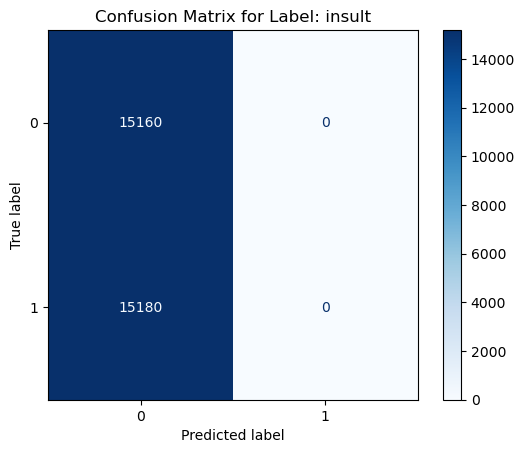

<Figure size 800x500 with 0 Axes>

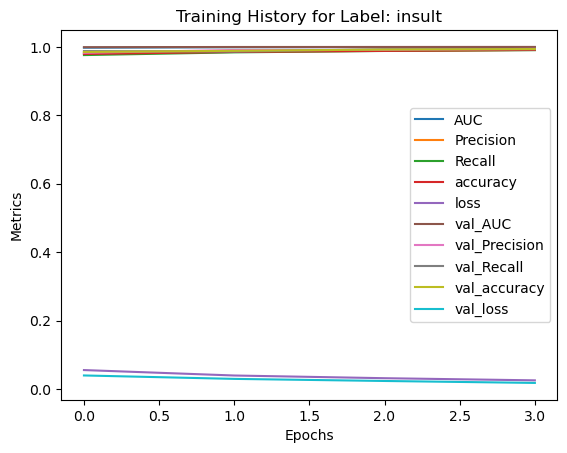

label:  identity_hate
Epoch 1/4
9227/9227 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - AUC: 0.9986 - Precision: 0.9905 - Recall: 0.9851 - accuracy: 0.9878 - loss: 0.0361
Epoch 1: saving model to models/model_identity_hate_1.keras
9227/9227 ━━━━━━━━━━━━━━━━━━━━ 3185s 345ms/step - AUC: 0.9986 - Precision: 0.9905 - Recall: 0.9851 - accuracy: 0.9878 - loss: 0.0361 - val_AUC: 0.9995 - val_Precision: 0.9945 - val_Recall: 0.9908 - val_accuracy: 0.9927 - val_loss: 0.0226
Epoch 2/4
9227/9227 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - AUC: 0.9994 - Precision: 0.9958 - Recall: 0.9910 - accuracy: 0.9934 - loss: 0.0199
Epoch 2: saving model to models/model_identity_hate_2.keras
9227/9227 ━━━━━━━━━━━━━━━━━━━━ 3515s 381ms/step - AUC: 0.9994 - Precision: 0.9958 - Recall: 0.9910 - accuracy: 0.9934 - loss: 0.0199 - val_AUC: 0.9998 - val_Precision: 0.9983 - val_Recall: 0.9929 - val_accuracy: 0.9956 - val_loss: 0.0129
Epoch 3/4
9227/9227 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - AUC: 0.9997 - Precision: 0.9966 - Recall: 0.9

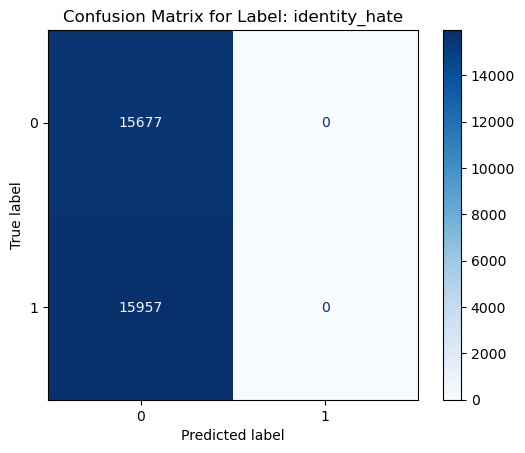

<Figure size 800x500 with 0 Axes>

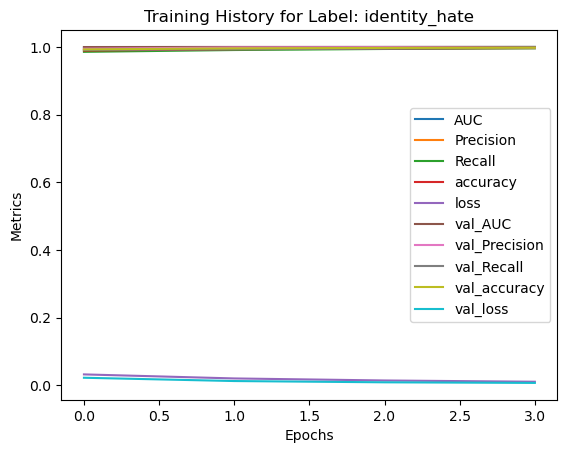

In [161]:
for label in oversampled_data:
    
    label_X = oversampled_data[label][0]
    label_y = oversampled_data[label][1]

    # Determine dataset size
    dataset_size = len(label_X)

   # Create tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((label_X, label_y)).cache().shuffle(dataset_size)

    # Split dataset into training, validation, and test sets
    train_size = int(dataset_size * 0.7)
    val_size = int(dataset_size * 0.2)

   # Split and batch datasets
    train_dataset = dataset.take(train_size).batch(24).prefetch(8)
    val_dataset = dataset.skip(train_size).take(val_size).batch(24).prefetch(8)
    test_dataset = dataset.skip(train_size + val_size).batch(24).prefetch(8)

    # Initialize ModelCheckpoint callback for this label
    checkpoint_callback = ModelCheckpoint(
        filepath=f'models/model_{label}_{{epoch}}.keras',  # Unique file for each label
        save_best_only=False,
        save_weights_only=False,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        train_dataset,
        epochs=4,
        validation_data=val_dataset,
        callbacks=[checkpoint_callback]
    )

    # Evaluate the model and unpack all returned values
    evaluation_results = model.evaluate(test_dataset, verbose=1)
    # Unpack each metric
    test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_results

    result[label] = {
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "test_precision" : test_precision,
        "test_recall" : test_recall,
        "test_auc" : test_auc
    }
    
    # Plot training history
    plt.figure(figsize=(8, 5))
    pd.DataFrame(history.history).plot()
    plt.title(f"Training History for Label: {label}")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.show()

In [163]:
# Print overall results
print("Test Results for All Labels:")
for label, metrics in result.items():
    print(f"Label: {label} - Loss: {metrics['test_loss']}, Accuracy: {metrics['test_accuracy']}")

Test Results for All Labels:
Label: toxic - Loss: 0.05374408885836601, Accuracy: 0.982673168182373
Label: obscene - Loss: 0.024187171831727028, Accuracy: 0.9920267462730408
Label: threat - Loss: 0.008375332690775394, Accuracy: 0.9976114630699158
Label: insult - Loss: 0.017190899699926376, Accuracy: 0.993671715259552
Label: identity_hate - Loss: 0.006439810153096914, Accuracy: 0.9977239966392517
